# Importar las librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import os
import pathlib
import random as rn
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score

In [2]:
# Montar Google Drive con el Dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Definir el directorio raíz del dataset en Google Drive
dataset_dir = "/content/drive/MyDrive/GTSRB_Dataset"

In [4]:
train_dir = os.path.join(dataset_dir, "Train")
test_dir = os.path.join(dataset_dir, "Test")

# Etiquetas

In [30]:
classes = { 0:'Límite de velocidad (20km/h)',
            1:'Límite de velocidad (30km/h)',
            2:'Límite de velocidad (50km/h)',
            3:'Límite de velocidad (60km/h)',
            4:'Límite de velocidad (70km/h)',
            5:'Límite de velocidad (80km/h)',
            6:'Fin de límite de velocidad (80km/h)',
            7:'Límite de velocidad (100km/h)',
            8:'Límite de velocidad (120km/h)',
            9:'Prohibido adelantar',
            10:'Prohibido adelantar a vehículos > 3.5 toneladas ',
            11:'Cruce de carreteras',
            12:'Comienzo de un camino prioritario',
            13:'Ceda el paso',
            14:'Stop',
            15:'Prohibida la entrada',
            16:'Prohibido Vehículos > 3.5 toneladas',
            17:'Dirección prohibida',
            18:'Peligro',
            19:'Advertencia por una curva a la izquierda',
            20:'Advertencia por una curva a la derecha',
            21:'Advertencia de doble curva',
            22:'Mala calzada',
            23:'Camino resbaladizo',
            24:'Ensanchamiento a la derecha',
            25:'Obra en la via',
            26:'Proximidad de semáforo',
            27:'Proximidad paso de cebra',
            28:'Zona de peatones',
            29:'Ciclistas en la vía',
            30:'Cuidado con el hielo/nieve',
            31:'Cruce de ciervos',
            32:'Fin de todas las prohibiciones',
            33:'Obligatorio girar a la derecha',
            34:'Obligatorio girar a la izquierda',
            35:'Solo adelante',
            36:'Sigue recto o a la derecha',
            37:'Sigue recto o a la izquierda',
            38:'Manténgase a la derecha',
            39:'Manténgase a la izquierda',
            40:'Rotonda obligatoria',
            41:'Fin de la prohibición de adelantar',
            42:'Fin de la prohibicion de adelantar vehículos > 3.5 toneladas' }

# Parámetros

In [6]:
HEIGHT = 50
WIDTH = 50
BATCH_SIZE = 4
SEED = 42

# Preparación de los Generadores de Datos de Entrenamiento y Validación

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(HEIGHT, WIDTH),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  seed=SEED,
                                                  color_mode='rgb',
                                                  interpolation='hamming',
                                                  subset='training')

test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.2)
test_dataset = test_datagen.flow_from_directory(train_dir,
                                                target_size=(HEIGHT, WIDTH),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True,
                                                seed=SEED,
                                                color_mode='rgb',
                                                interpolation='hamming',
                                                subset='validation')

Found 28335 images belonging to 43 classes.
Found 7064 images belonging to 43 classes.


# Visualización Aleatoria de Imágenes del Conjunto de Entrenamiento

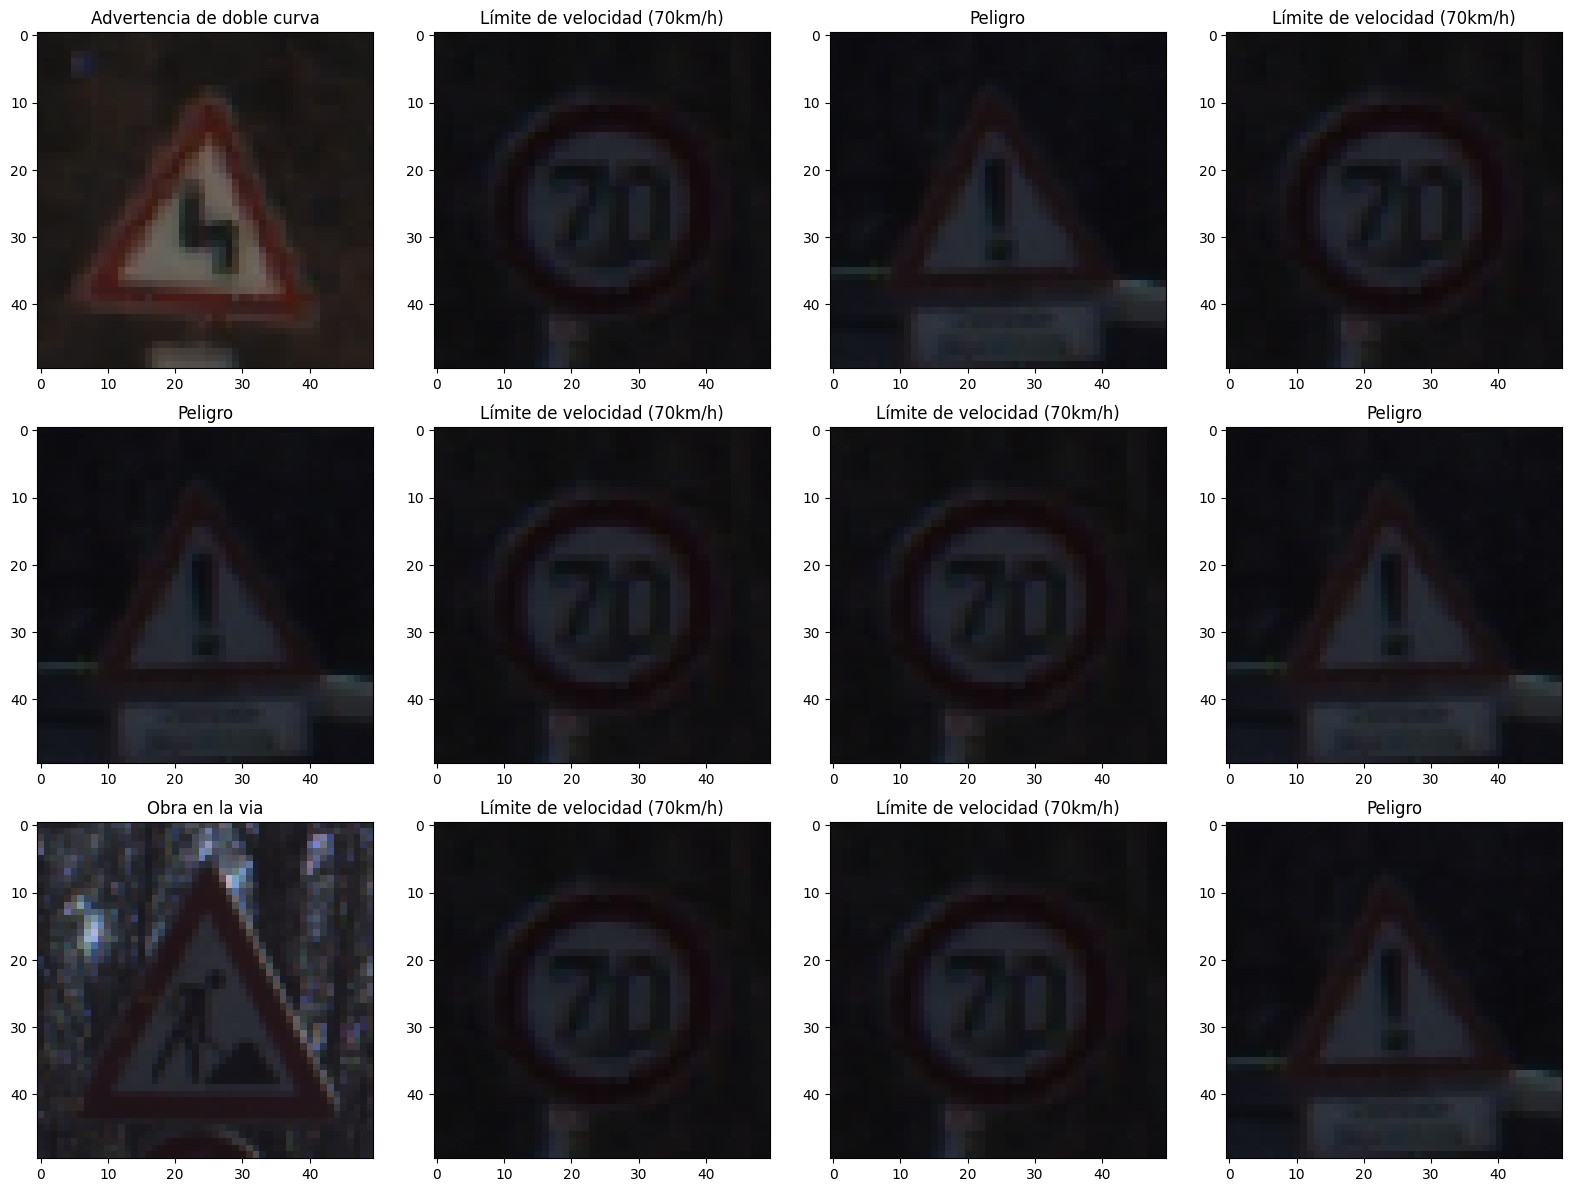

In [32]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# Obtener unas imágenes
img, y = next(iter(train_dataset))

for i in range(3):
    for j in range(4):
        l = np.random.randint(0, img.shape[0])
        label = classes[int(list(train_dataset.class_indices.keys())[np.argmax(y[l])])]
        ax[i, j].imshow(img[l])
        ax[i, j].set_title(label)

plt.tight_layout()

# Definición del Modelo de Red Neuronal Convolucional (CNN)

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(HEIGHT,WIDTH,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.25),

    keras.layers.Dense(43, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 46, 46, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 42, 42, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 21, 21, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 21, 21, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 19, 19, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 17, 17, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,191,627 (8.36 MB)

 Trainable params: 2,190,411 (8.36 MB)

 Non-trainable params: 1,216 (4.75 KB)

# Configuración del Optimizador y Compilación del Modelo

In [12]:
alpha=0.0001
epochs=30
optim = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
epochs = 10   # número de epocas en el entrenamiento

history = model.fit(train_dataset, epochs= epochs, verbose= 1, validation_data= test_dataset, shuffle= False)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7084/7084 ━━━━━━━━━━━━━━━━━━━━ 7483s 1s/step - accuracy: 0.5666 - loss: 1.7336 - val_accuracy: 0.9376 - val_loss: 0.2124
Epoch 2/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - accuracy: 0.9383 - loss: 0.2353 - val_accuracy: 0.9509 - val_loss: 0.1748
Epoch 3/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9648 - loss: 0.1299 - val_accuracy: 0.9681 - val_loss: 0.1108
Epoch 4/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9759 - loss: 0.0898 - val_accuracy: 0.9655 - val_loss: 0.1116
Epoch 5/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9811 - loss: 0.0699 - val_accuracy: 0.9757 - val_loss: 0.0813
Epoch 6/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9844 - loss: 0.0595 - val_accuracy: 0.9680 - val_loss: 0.1013
Epoch 7/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 87s 12ms/step - accuracy: 0.9866 - loss: 0.0491 - val_accuracy: 0.9742 - val_loss: 0.0969
Epoch 8/10
7084/7084 ━━━━━━━━━━━━━━━━━━━━ 88s 12ms/step - accuracy: 0.9890 - loss: 0.04

# Visualización del Rendimiento del Modelo: Accuracy y Loss

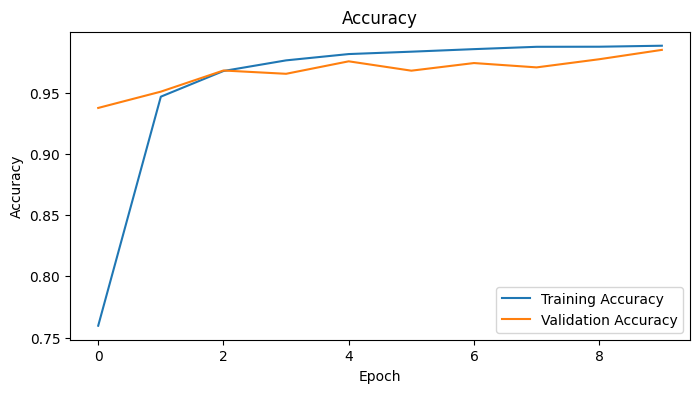

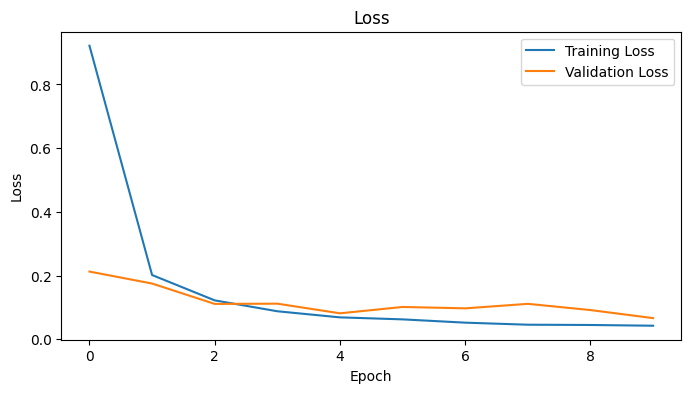

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluación del Modelo en Conjuntos de Entrenamiento y Validación

In [15]:
train_score = model.evaluate(train_dataset, verbose= 1)
valid_score = model.evaluate(test_dataset, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])

7084/7084 ━━━━━━━━━━━━━━━━━━━━ 69s 10ms/step - accuracy: 1.0000 - loss: 2.6903e-04
1766/1766 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9822 - loss: 0.0751
Train Loss:  0.00029041568632237613
Train Accuracy:  0.999964714050293
--------------------
Validation Loss:  0.06623019278049469
Validation Accuracy:  0.9849943518638611


In [16]:
# Guardado del modelo entrenado
model.save("CnnModel.h5")

# Carga y Preprocesamiento de Imágenes de Prueba desde CSV

In [23]:
import os
import numpy as np
import cv2
from PIL import Image
import pandas as pd

def map_pred(pred):
    return [int(list(train_dataset.class_indices.keys())[i]) for i in pred]

# Cargar archivo CSV
test_csv = os.path.join(dataset_dir, "Test.csv")
test_df = pd.read_csv(test_csv)

# Extraer etiquetas y rutas de imágenes
test_labels = test_df["ClassId"].values
imgs = test_df["Path"].values

data = []

for img in imgs:
    try:
        image_path = os.path.join(dataset_dir, img)
        with Image.open(image_path) as image:
            image = image.convert('RGB')  # Asegurar formato RGB
            resize_image = image.resize((HEIGHT, WIDTH))
            data.append(np.array(resize_image))
    except Exception as e:
        print(f"Error with image {img}: {e}")

# Convertir a array y normalizar
X_test = np.array(data, dtype=np.float32) / 255.0

In [24]:
# Predicción y evaluación de precisión en el conjunto de datos de prueba
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
pred = map_pred(pred.argmax(axis=-1))
print('Test Data accuracy: ',accuracy_score(test_labels, pred)*100)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Data accuracy:  97.79097387173397


# Visualización de Métricas de Desempeño del Modelo

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from scipy.interpolate import interp1d

# Preparar las predicciones para métricas
pred_proba = model.predict(X_test)
pred = map_pred(pred_proba.argmax(axis=-1))

# Exactitud (Accuracy)
accuracy = accuracy_score(test_labels, pred) * 100

# Precisión (Precision)
precision = precision_score(test_labels, pred, average='weighted') * 100

# Recall
recall = recall_score(test_labels, pred, average='weighted') * 100

# F1 Score
f1 = f1_score(test_labels, pred, average='weighted') * 100


print("Métricas de Desempeño Globales")
print(f"Exactitud (Accuracy): {accuracy:.2f}%")
print(f"Precisión (Precision): {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Métricas de Desempeño Globales
Exactitud (Accuracy): 97.79%
Precisión (Precision): 97.81%
Recall: 97.79%
F1 Score: 97.77%


# Visualización de la Matriz de Confusión

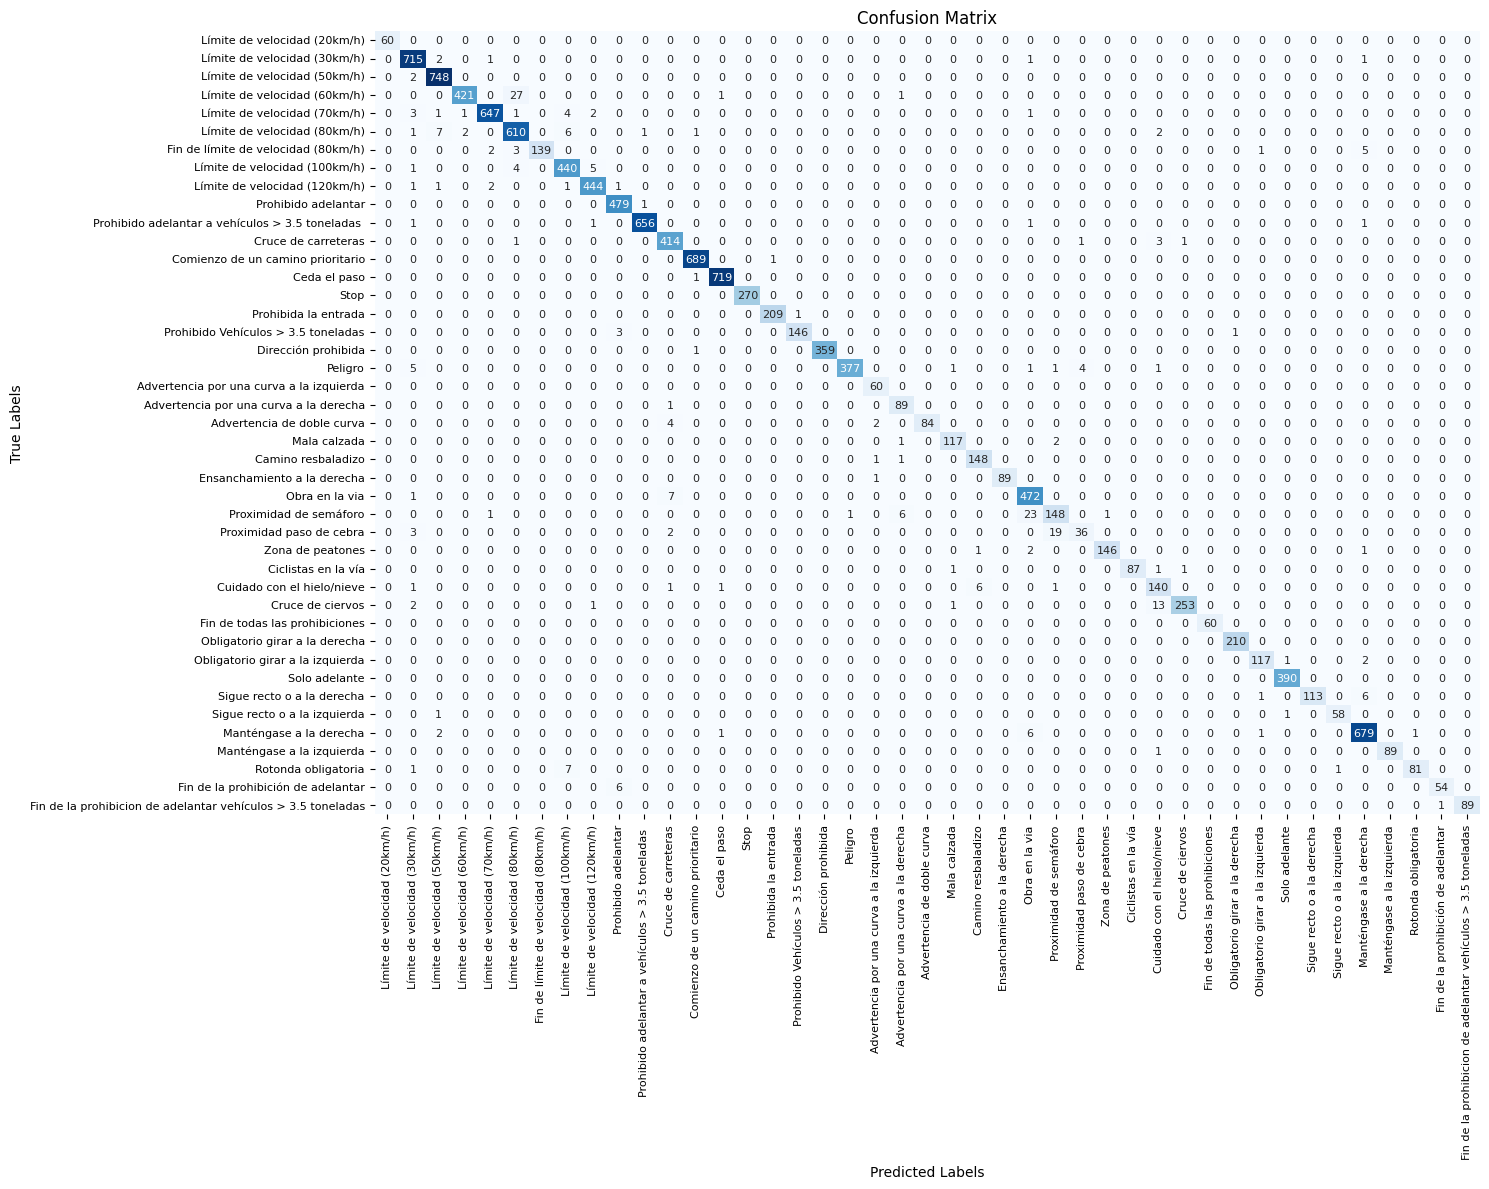

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = list(classes.values())

# Calcular la matriz de confusión
cm = confusion_matrix(test_labels, pred)

# Plot matrix de confusión
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"fontsize": 8})

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.xticks(np.arange(len(classes)) + 0.5, classes.values(), rotation=90, ha='center', fontsize=8)
plt.yticks(np.arange(len(classes)) + 0.5, classes.values(), rotation=0, ha='right', fontsize=8)

plt.tight_layout()  # Ajusta automáticamente los márgenes
plt.show()

# Visualización de Predicciones del Modelo en Imágenes de Validación

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


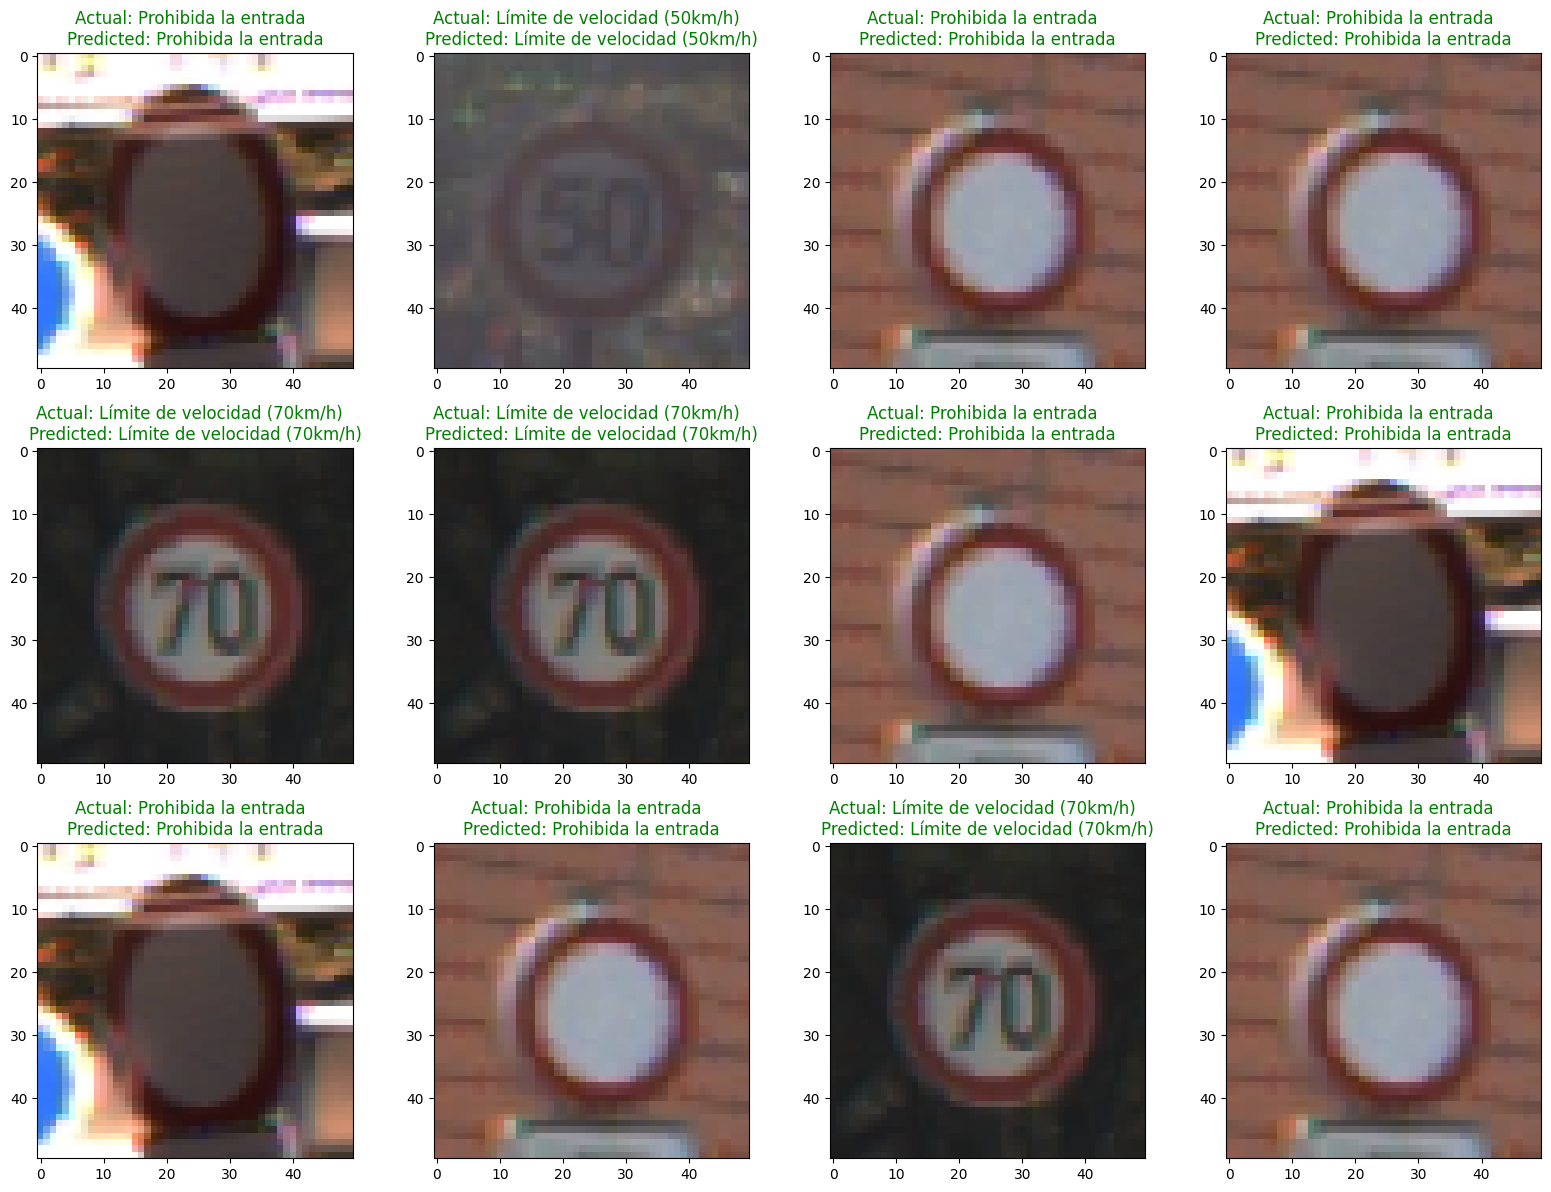

In [42]:
fig,ax=plt.subplots(3,4)
fig.set_size_inches(16,12)
val_images, val_labels = test_dataset[0]
predicted = model.predict(val_images)
predicts = map_pred(np.argmax(predicted, axis=-1))
labels = map_pred(np.argmax(val_labels, axis=-1))

for i in range(3):
    for j in range (4):
        idx=rn.randint(0,BATCH_SIZE-1)
        ax[i,j].imshow(val_images[idx])
        if labels[idx] == predicts[idx]:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'green')
        else:
            ax[i,j].set_title('Actual: '+classes[labels[idx]]+'  \nPredicted: '+classes[predicts[idx]], color = 'red')

plt.tight_layout()